In [1]:
# This notebook was ran on kaggle with GPU T4 x2

# importing necessary libraries
import os
import librosa
import numpy as np
import random
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

2024-05-02 17:50:16.563355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 17:50:16.563444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 17:50:16.734287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define genres and their corresponding labels
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

dataset = []
  
# Define parameters for feature extraction
# Dividing in segments for reducing computational cost
segment_duration = 5  # Duration of each segment in seconds
hop_length = 256
n_fft = 512
n_mels = 64

# Iterate over each genre and its corresponding label
for genre, label in genres.items():
    genre_dir = f'/kaggle/input/gtzan-genre-collection/genres/{genre}'
    
    # Iterate over each audio file in the genre directory
    for filename in os.listdir(genre_dir):
        songname = os.path.join(genre_dir, filename)
        
        # Load the audio file
        y, sr = librosa.load(songname, mono=True, duration=30)  # Load the entire 30-second audio
        
        # Split the audio into segments
        num_segments = len(y) // (segment_duration * sr)
        for index in range(num_segments):
            start_sample = index * segment_duration * sr
            end_sample = start_sample + segment_duration * sr
            segment = y[start_sample:end_sample] 
            
            # Extract Mel spectrogram features
            ps = librosa.feature.melspectrogram(y=segment, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=n_mels)
            ps_db = librosa.power_to_db(ps, ref=np.max)
            
            # Append features and label to the dataset
            dataset.append((ps_db, label))

print(len(dataset))

5991


In [3]:
random.shuffle(dataset)

first_features, first_label = dataset[0]
second_features, second_label = dataset[1]

print(first_features.shape, second_features.shape)
print(first_label, second_label)

(64, 431) (64, 431)
2 3


In [4]:
dataset[0]

(array([[-31.562538, -27.863014, -35.13977 , ..., -21.650532, -20.571318,
         -29.053751],
        [-27.297169, -21.638004, -23.496876, ..., -19.137266, -14.572704,
         -21.858316],
        [-26.102621, -23.667671, -16.98384 , ..., -16.840944, -14.188402,
         -15.637913],
        ...,
        [-70.031044, -80.      , -80.      , ..., -80.      , -80.      ,
         -68.3105  ],
        [-70.24416 , -80.      , -80.      , ..., -80.      , -80.      ,
         -68.45467 ],
        [-70.32183 , -80.      , -80.      , ..., -80.      , -80.      ,
         -68.540215]], dtype=float32),
 2)

The Numpy array represents the Mel spectrogram of that song.
Mel spectrogram is the loudness of each frequency of the sound in a time series.

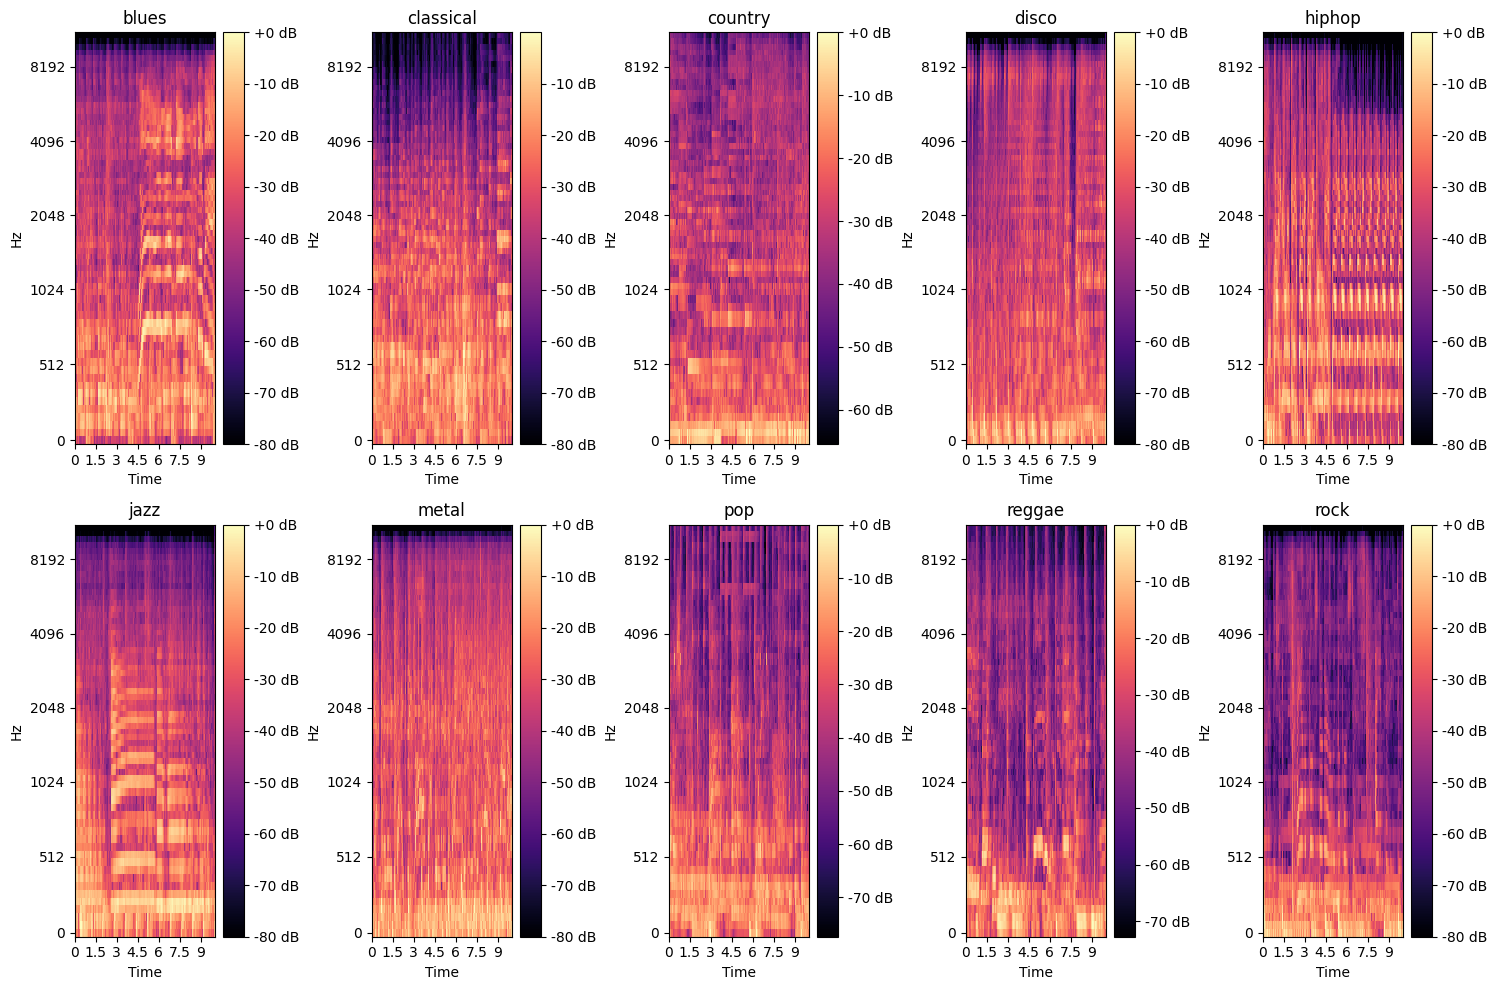

In [5]:
# Choose a random sample for each genre
random_samples = []
for label in range(10):
    genre_samples = [item[0] for item in dataset if item[1] == label]
    random_sample = genre_samples[np.random.randint(len(genre_samples))]
    random_samples.append(random_sample)

# Plot Mel spectrograms for each genre
plt.figure(figsize=(15, 10))
for i, sample in enumerate(random_samples):
    plt.subplot(2, 5, i + 1)
    librosa.display.specshow(sample, sr=22050, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(list(genres.keys())[i])
plt.tight_layout()
plt.show()

In [6]:
#MusiCNN

# Convert features and labels to numpy arrays
X = np.array([item[0] for item in dataset])
y = np.array([item[1] for item in dataset])

# Reshape the spectrograms to flatten them
X_flat = X.reshape(X.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Reshape the scaled features back to the original shape
X_scaled = X_scaled.reshape(X.shape)

# One-hot encode the labels
y_onehot = to_categorical(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# Reshape the input data to fit the model input shape
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# running only 20 epochs because it is clear, after 12-13 epochs that the model is overfitting.

Epoch 1/20
  7/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1507 - loss: 7.2260 

I0000 00:00:1714672335.773445      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714672335.792052      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2165 - loss: 3.0237

W0000 00:00:1714672348.019728      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.2168 - loss: 3.0186 - val_accuracy: 0.4504 - val_loss: 1.7091
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3978 - loss: 1.6984 - val_accuracy: 0.5413 - val_loss: 1.3323
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4943 - loss: 1.4118 - val_accuracy: 0.6272 - val_loss: 1.1162
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5590 - loss: 1.2398 - val_accuracy: 0.6514 - val_loss: 1.0426
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6511 - loss: 1.0079 - val_accuracy: 0.6380 - val_loss: 1.0168
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7010 - loss: 0.8582 - val_accuracy: 0.6614 - val_loss: 1.0135
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7339 - loss: 0.7375 - val_accuracy: 0.6689 - val_loss: 0.9673
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7888 - loss: 0.5962 - val_accuracy: 0.67

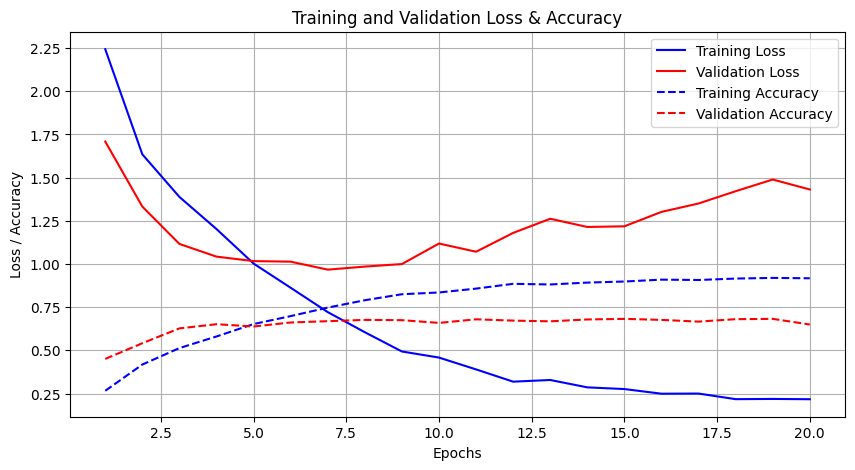

In [8]:
# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plot loss and accuracy on the same graph
plt.figure(figsize=(10, 5))

# Plot loss
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')

# Plot accuracy
plt.plot(epochs, training_accuracy, 'b--', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r--', label='Validation Accuracy')

plt.title('Training and Validation Loss & Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Reshape the input data to fit the VGG model input shape
X_rgb = np.stack((X,) * 3, axis=-1)  # Convert mono to pseudo-RGB channels

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rgb.reshape(-1, X_rgb.shape[-1])).reshape(X_rgb.shape)

# One-hot encode the labels
y_onehot = to_categorical(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add fully connected layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Adding L2 regularization
model.add(Dropout(0.5))  # Adding dropout
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/50
  2/150 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.1406 - loss: 3.4014   

W0000 00:00:1714672473.667001      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.3216 - loss: 2.0979

W0000 00:00:1714672504.385195      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714672506.446594      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/150 ━━━━━━━━━━━━━━━━━━━━ 75s 329ms/step - accuracy: 0.3221 - loss: 2.0961 - val_accuracy: 0.6113 - val_loss: 1.3316
Epoch 2/50
  1/150 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.4375 - loss: 1.5291

W0000 00:00:1714672522.736901      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.4980 - loss: 1.4525 - val_accuracy: 0.6339 - val_loss: 1.2028
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.5252 - loss: 1.3649 - val_accuracy: 0.6806 - val_loss: 1.0683
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.5781 - loss: 1.2506 - val_accuracy: 0.7023 - val_loss: 1.0096
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.5719 - loss: 1.2475 - val_accuracy: 0.7173 - val_loss: 1.0604
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.5953 - loss: 1.2181 - val_accuracy: 0.7223 - val_loss: 0.9837
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.6270 - loss: 1.1344 - val_accuracy: 0.7023 - val_loss: 1.0019
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.6452 - loss: 1.1103 - val_accuracy: 0.7314 - val_loss: 0.9763
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.6308 - loss: 1.1242 - val_accurac

In [12]:
# experimenting with reduce_lr
# running 2 .fit of 50 epochs as sometimes the kernel was crashing after 60-70 epochs

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.6411 - loss: 1.1082 - val_accuracy: 0.7073 - val_loss: 1.0750 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.6339 - loss: 1.1197 - val_accuracy: 0.7339 - val_loss: 1.0372 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.6535 - loss: 1.0604 - val_accuracy: 0.7173 - val_loss: 1.0306 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.6681 - loss: 1.0292 - val_accuracy: 0.7098 - val_loss: 1.0717 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.6553 - loss: 1.0621 - val_accuracy: 0.6656 - val_loss: 1.1624 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.6094 - loss: 1.1770 - val_accuracy: 0.7298 - val_loss: 1.0310 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.6705 - l

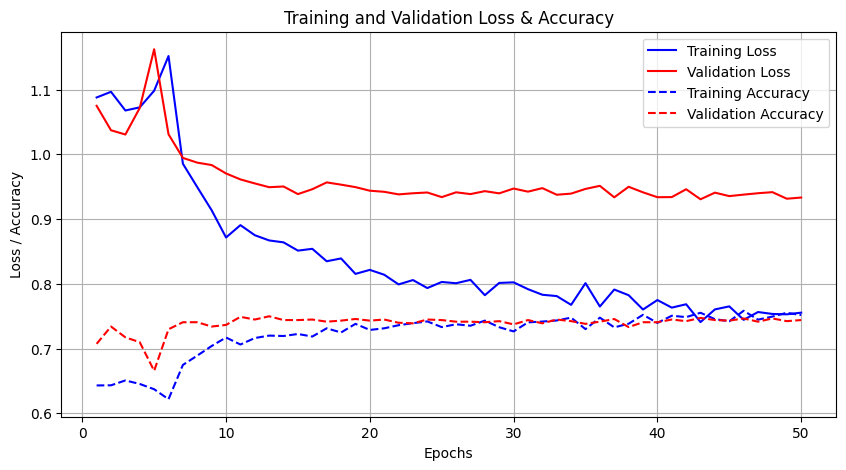

In [13]:
# Extract training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plot loss and accuracy on the same graph
plt.figure(figsize=(10, 5))

# Plot loss
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')

# Plot accuracy
plt.plot(epochs, training_accuracy, 'b--', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r--', label='Validation Accuracy')

plt.title('Training and Validation Loss & Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Experimenting to check whether the non-deep learning models are suitable for this job or not

# Flatten each spectrogram
X_flat = np.array([spectrogram.flatten() for spectrogram in X])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Predict labels for test data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.5479566305254379
